### Import

In [1]:
import os

In [2]:
import numpy as np
import pandas as pd

In [3]:
from tqdm import tqdm
import itertools

In [4]:
from keras import backend as K
from keras.layers import Input
from keras.callbacks import ModelCheckpoint
from keras.layers.core import Activation, Dense, Dropout, Lambda
from keras.layers.merge import Concatenate
from keras.models import Model, load_model
from keras.utils import np_utils
from keras.utils import to_categorical

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Using TensorFlow backend.


In [5]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [6]:
import os
import pickle
import itertools

In [7]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

### Data

In [8]:
os.listdir()

['.ipynb_checkpoints',
 'sample_submission.csv',
 'test',
 'train_relationships.csv',
 'recognizing-faces-in-the-wild.zip',
 'data',
 '01-keras-nn-with-vectorization.ipynb',
 'train']

In [9]:
sample_submission = pd.read_csv("sample_submission.csv")
print(sample_submission.shape)
sample_submission.head(3)

(5310, 2)


,img_pair,is_related
0,face05508.jpg-face01210.jpg,0
1,face05750.jpg-face00898.jpg,0
2,face05820.jpg-face03938.jpg,0


In [10]:
train_relationships = pd.read_csv("train_relationships.csv")
print(train_relationships.shape)
train_relationships.head()

(3598, 2)


,p1,p2
0,F0002/MID1,F0002/MID3
1,F0002/MID2,F0002/MID3
2,F0005/MID1,F0005/MID2
3,F0005/MID3,F0005/MID2
4,F0009/MID1,F0009/MID4


### Data preparation

In [11]:
train_relationships["target"] = 1
train_relationships.head()

,p1,p2,target
0,F0002/MID1,F0002/MID3,1
1,F0002/MID2,F0002/MID3,1
2,F0005/MID1,F0005/MID2,1
3,F0005/MID3,F0005/MID2,1
4,F0009/MID1,F0009/MID4,1


In [12]:
relation_df = train_relationships

In [13]:
for value in tqdm(train_relationships.p1.values):
    relation = train_relationships.p2.loc[train_relationships.p1 == value]
    relation = relation.values
    new_value = train_relationships.p2.sample(n=2).values
    
    relation_df = relation_df.append({
        "p1": relation[0],
        "p2": new_value[0],
        "target": 0
    }, ignore_index=True)
    
    relation_df = relation_df.append({
        "p1": relation[0],
        "p2": new_value[1],
        "target": 0
    }, ignore_index=True)

100%|██████████| 3598/3598 [00:14<00:00, 247.28it/s]


In [14]:
relation_arr_0 = relation_df.loc[relation_df.target == 0].values
relation_arr_0[0]

array(['F0002/MID3', 'F0303/MID10', 0], dtype=object)

In [15]:
relation_arr_1 = relation_df.loc[relation_df.target == 1].values
relation_arr_1[0]

array(['F0002/MID1', 'F0002/MID3', 1], dtype=object)

In [16]:
incorrect_values = []
for arr_0 in relation_arr_0:
    for arr_1 in relation_arr_1:
        if (arr_0[0] == arr_1[0]) and (arr_0[1] == arr_1[1]):
            print(arr_0, arr_1)
            incorrect_values.append([arr_0[0], arr_0[1]])

['F0290/MID3' 'F0290/MID6' 0] ['F0290/MID3' 'F0290/MID6' 1]
['F0303/MID8' 'F0303/MID10' 0] ['F0303/MID8' 'F0303/MID10' 1]
['F0357/MID6' 'F0357/MID9' 0] ['F0357/MID6' 'F0357/MID9' 1]
['F0820/MID4' 'F0820/MID5' 0] ['F0820/MID4' 'F0820/MID5' 1]


In [17]:
incorrect_values

[['F0290/MID3', 'F0290/MID6'],
 ['F0303/MID8', 'F0303/MID10'],
 ['F0357/MID6', 'F0357/MID9'],
 ['F0820/MID4', 'F0820/MID5']]

In [18]:
# df.drop(df.loc[df['line_race']==0].index, inplace=True)
for iv in incorrect_values:
    print(iv)
    relation_df.drop(relation_df.loc[(relation_df.p1 == iv[0])&(relation_df.p2==iv[1])&(relation_df.target==0)].index, inplace=True)

['F0290/MID3', 'F0290/MID6']
['F0303/MID8', 'F0303/MID10']
['F0357/MID6', 'F0357/MID9']
['F0820/MID4', 'F0820/MID5']


In [19]:
relation_df.head()

,p1,p2,target
0,F0002/MID1,F0002/MID3,1
1,F0002/MID2,F0002/MID3,1
2,F0005/MID1,F0005/MID2,1
3,F0005/MID3,F0005/MID2,1
4,F0009/MID1,F0009/MID4,1


In [20]:
relation_df = relation_df.sample(frac=1).reset_index(drop=True)
relation_df.head()

,p1,p2,target
0,F0402/MID8,F0402/MID6,1
1,F0456/MID3,F0805/MID5,0
2,F0825/MID6,F0825/MID10,1
3,F0423/MID2,F0664/MID3,0
4,F0237/MID3,F0425/MID4,0


### Next steps of data preparation

In [21]:
test1 = os.listdir("train/F0801/MID1/")
print(test1)
test2 = os.listdir("train/F0801/MID2/")
print(test2)

['P08475_face2.jpg', 'P08473_face1.jpg']
['P08474_face1.jpg', 'P08476_face1.jpg', 'P08473_face2.jpg', 'P08475_face1.jpg']


In [22]:
for l in list(itertools.product(test1, test2)):
    print(l)

('P08475_face2.jpg', 'P08474_face1.jpg')
('P08475_face2.jpg', 'P08476_face1.jpg')
('P08475_face2.jpg', 'P08473_face2.jpg')
('P08475_face2.jpg', 'P08475_face1.jpg')
('P08473_face1.jpg', 'P08474_face1.jpg')
('P08473_face1.jpg', 'P08476_face1.jpg')
('P08473_face1.jpg', 'P08473_face2.jpg')
('P08473_face1.jpg', 'P08475_face1.jpg')


In [23]:
PATH = "train/"

In [24]:
train_data = []
for row in relation_df.values:
    try:
        
        path1 = os.path.join(PATH, row[0])
        path2 = os.path.join(PATH, row[1])

        arr_of_img_1 = os.listdir(path1)
        arr_of_img_2 = os.listdir(path2)

        arr_of_img_1 = [os.path.join(path1, img) for img in arr_of_img_1]
        arr_of_img_2 = [os.path.join(path2, img) for img in arr_of_img_2]

        combinations = list(itertools.product(arr_of_img_1, arr_of_img_2))
        for com in combinations:
            train_data.append([com[0], com[1], row[2]])
    except:
        print(row)

['F0439/MID8' 'F0425/MID8' 0]
['F0801/MID4' 'F0734/MID3' 0]
['F0646/MID5' 'F0439/MID8' 0]
['F0303/MID10' 'F0825/MID7' 0]
['F0360/MID4' 'F0498/MID3' 0]
['F0174/MID4' 'F0825/MID8' 0]
['F0129/MID7' 'F0603/MID3' 0]
['F0548/MID4' 'F0339/MID2' 0]
['F0438/MID4' 'F0438/MID7' 1]
['F0435/MID4' 'F0070/MID3' 0]
['F0809/MID4' 'F0773/MID3' 0]
['F0825/MID2' 'F0825/MID8' 1]
['F0809/MID6' 'F0809/MID1' 1]
['F0249/MID9' 'F0299/MID4' 0]
['F0238/MID8' 'F0561/MID4' 0]
['F0818/MID8' 'F0091/MID4' 0]
['F0238/MID8' 'F0646/MID6' 0]
['F0203/MID9' 'F0591/MID3' 0]
['F0456/MID3' 'F0426/MID6' 0]
['F0601/MID5' 'F0264/MID5' 0]
['F0746/MID2' 'F0498/MID3' 0]
['F0051/MID3' 'F0135/MID4' 0]
['F0197/MID5' 'F0482/MID4' 0]
['F0658/MID8' 'F0439/MID9' 0]
['F0908/MID5' 'F0829/MID4' 0]
['F0081/MID3' 'F0081/MID1' 1]
['F0825/MID5' 'F0825/MID7' 1]
['F0678/MID3' 'F0326/MID5' 0]
['F0203/MID9' 'F0203/MID3' 0]
['F0439/MID8' 'F0742/MID3' 0]
['F0238/MID8' 'F0783/MID5' 0]
['F0908/MID5' 'F0959/MID2' 0]
['F0768/MID1' 'F0768/MID5' 1]
['F0241/M

['F0264/MID9' 'F0264/MID5' 1]
['F0254/MID6' 'F0254/MID4' 1]
['F0209/MID5' 'F0625/MID6' 0]
['F0908/MID5' 'F0049/MID5' 0]
['F0202/MID5' 'F0973/MID4' 0]
['F0302/MID4' 'F0818/MID9' 0]
['F0233/MID6' 'F0238/MID8' 0]
['F0393/MID1' 'F0393/MID6' 1]
['F0601/MID11' 'F0708/MID4' 0]
['F0806/MID2' 'F0299/MID4' 0]
['F0091/MID3' 'F0091/MID5' 1]
['F0811/MID8' 'F0498/MID3' 0]
['F0285/MID5' 'F0818/MID9' 0]
['F0206/MID5' 'F0206/MID3' 1]
['F0099/MID6' 'F0228/MID3' 0]
['F0642/MID7' 'F0498/MID3' 0]
['F0801/MID4' 'F0192/MID3' 0]
['F0524/MID4' 'F0993/MID2' 0]
['F0393/MID6' 'F0036/MID7' 0]
['F0601/MID27' 'F0135/MID4' 0]
['F0309/MID2' 'F0309/MID4' 1]
['F0264/MID5' 'F0118/MID6' 0]
['F0825/MID8' 'F0881/MID4' 0]
['F0728/MID4' 'F0678/MID3' 0]
['F0238/MID7' 'F0238/MID8' 1]
['F0091/MID1' 'F0091/MID5' 1]
['F0238/MID4' 'F0498/MID3' 0]
['F0264/MID1' 'F0264/MID5' 1]
['F0744/MID1' 'F0744/MID3' 1]
['F0825/MID8' 'F0854/MID4' 0]
['F0438/MID4' 'F0438/MID2' 1]
['F0206/MID6' 'F0206/MID3' 1]
['F0299/MID5' 'F0825/MID8' 0]
['F0206/

['F0503/MID8' 'F0439/MID8' 0]
['F0687/MID1' 'F0687/MID3' 1]
['F0446/MID6' 'F0914/MID3' 0]
['F0129/MID7' 'F0818/MID3' 0]
['F0215/MID4' 'F0215/MID8' 1]
['F0708/MID4' 'F0101/MID1' 0]
['F0255/MID4' 'F0744/MID4' 0]
['F0548/MID4' 'F0960/MID5' 0]
['F0762/MID3' 'F0393/MID3' 0]
['F0206/MID2' 'F0206/MID14' 1]
['F0465/MID1' 'F0818/MID8' 0]
['F0625/MID5' 'F0625/MID6' 1]
['F0498/MID5' 'F0498/MID1' 1]
['F0228/MID3' 'F0262/MID6' 0]
['F0809/MID4' 'F0128/MID7' 0]
['F0262/MID3' 'F0262/MID7' 1]
['F0393/MID6' 'F0831/MID1' 0]
['F0908/MID5' 'F0009/MID4' 0]
['F0099/MID6' 'F0426/MID6' 0]
['F0309/MID4' 'F0988/MID3' 0]
['F0809/MID5' 'F0809/MID4' 1]
['F0456/MID4' 'F0908/MID5' 0]
['F0825/MID8' 'F0064/MID3' 0]
['F0129/MID7' 'F0517/MID5' 0]
['F0599/MID3' 'F0091/MID5' 0]
['F0791/MID7' 'F0785/MID5' 0]
['F0897/MID1' 'F0897/MID7' 1]
['F0479/MID4' 'F0744/MID3' 0]
['F0129/MID7' 'F0895/MID3' 0]
['F0908/MID5' 'F0052/MID4' 0]
['F0118/MID5' 'F0498/MID3' 0]
['F0708/MID4' 'F0283/MID5' 0]
['F0238/MID8' 'F0113/MID2' 0]
['F0160/M

In [25]:
train_data = np.array(train_data)
train_data.shape

(326517, 3)

In [26]:
train_df = pd.DataFrame(train_data)
train_df.head()

,0,1,2
0,train/F0402/MID8/P04237_face2.jpg,train/F0402/MID6/P04235_face1.jpg,1
1,train/F0402/MID8/P04237_face2.jpg,train/F0402/MID6/P04236_face6.jpg,1
2,train/F0402/MID8/P04237_face2.jpg,train/F0402/MID6/P04234_face5.jpg,1
3,train/F0456/MID3/P04817_face1.jpg,train/F0805/MID5/P08523_face2.jpg,0
4,train/F0456/MID3/P04817_face1.jpg,train/F0805/MID5/P08521_face6.jpg,0


In [27]:
train_df[2].value_counts()

1    165179
0    161338
Name: 2, dtype: int64

### Vectorizer

In [28]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.models import Model
import numpy as np

class Img2Vec():

    def __init__(self):

        model = ResNet50(weights='imagenet')

        layer_name = 'avg_pool'
        self.intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)


    def get_vec(self, image_path):
        """ Gets a vector embedding from an image
        :param image_path: path to image on filesystem
        :returns: numpy ndarray
        """

        img = image.load_img(image_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        intermediate_output = self.intermediate_layer_model.predict(x)
        
        return intermediate_output[0]

In [29]:
img2vec = Img2Vec()

Instructions for updating:
Colocations handled automatically by placer.


### Vectorization

In [30]:
from keras.utils import to_categorical

In [31]:
train_data = np.array(train_data)
train_data.shape

(326517, 3)

In [32]:
X1, X2, Y = [], [], []
for pair in tqdm(train_data):
    x1_vec = img2vec.get_vec(pair[0])
    X1.append(x1_vec)
    x2_vec = img2vec.get_vec(pair[1])
    X2.append(x2_vec)
    y_true = pair[2]
    Y.append(y_true)

100%|██████████| 326517/326517 [23:33:03<00:00,  2.59it/s]   


In [33]:
Y = to_categorical(Y)

In [11]:
VECTOR_SIZE = 2048

In [35]:
import pickle

with open('data/x1_data.pkl', 'wb') as f:
    pickle.dump(X1, f)

with open('data/x2_data.pkl', 'wb') as f:
    pickle.dump(X2, f)

with open('data/y_data.pkl', 'wb') as f:
    pickle.dump(Y, f)

In [8]:
import pickle

In [9]:
with open('data/x1_data.pkl', 'rb') as f:
    X1 = pickle.load(f)

with open('data/x2_data.pkl', 'rb') as f:
    X2 = pickle.load(f)

with open('data/y_data.pkl', 'rb') as f:
    Y = pickle.load(f)

### Modeling

In [12]:
input_1 = Input(shape=(VECTOR_SIZE,))
input_2 = Input(shape=(VECTOR_SIZE,))
merged = Concatenate(axis=-1)([input_1, input_2])

fc1 = Dense(512, kernel_initializer="glorot_uniform")(merged)
fc1 = Dropout(0.2)(fc1)
fc1 = Activation("relu")(fc1)

fc2 = Dense(128, kernel_initializer="glorot_uniform")(fc1)
fc2 = Dropout(0.2)(fc2)
fc2 = Activation("relu")(fc2)

pred = Dense(2, kernel_initializer="glorot_uniform")(fc2)
pred = Activation("softmax")(pred)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
model = Model(inputs=[input_1, input_2], outputs=pred)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 4096)         0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          2097664     concatenate_1[0][0]              
__________

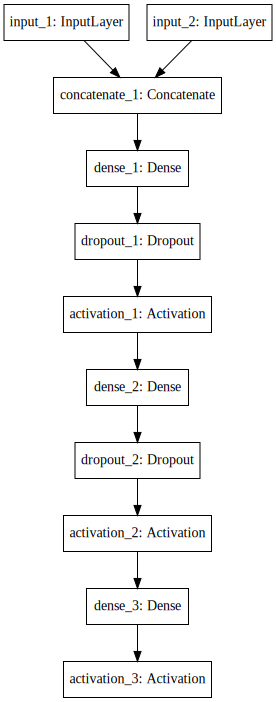

In [14]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [15]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [16]:
history = model.fit(
    [X1, X2], Y, 
    epochs=100, 
    validation_split=0.1
)

Instructions for updating:
Use tf.cast instead.
Train on 293865 samples, validate on 32652 samples
Epoch 1/100
293865/293865 [==============================] - 314s 1ms/step - loss: 0.4802 - acc: 0.7541 - val_loss: 0.5154 - val_acc: 0.7401
Epoch 2/100
293865/293865 [==============================] - 292s 994us/step - loss: 0.3493 - acc: 0.8376 - val_loss: 0.4901 - val_acc: 0.7665
Epoch 3/100
293865/293865 [==============================] - 264s 898us/step - loss: 0.2867 - acc: 0.8722 - val_loss: 0.4746 - val_acc: 0.7872
Epoch 4/100
293865/293865 [==============================] - 273s 928us/step - loss: 0.2514 - acc: 0.8896 - val_loss: 0.4680 - val_acc: 0.7991
Epoch 5/100
293865/293865 [==============================] - 250s 851us/step - loss: 0.2226 - acc: 0.9038 - val_loss: 0.4430 - val_acc: 0.8091
Epoch 6/100
293865/293865 [==============================] - 267s 908us/step - loss: 0.2015 - acc: 0.9134 - val_loss: 0.4778 - val_acc: 0.8135
Epoch 7/100
293865/293865 [==================

Epoch 56/100
293865/293865 [==============================] - 308s 1ms/step - loss: 0.0607 - acc: 0.9751 - val_loss: 0.8715 - val_acc: 0.8329
Epoch 57/100
293865/293865 [==============================] - 312s 1ms/step - loss: 0.0611 - acc: 0.9750 - val_loss: 0.7934 - val_acc: 0.8414
Epoch 58/100
293865/293865 [==============================] - 312s 1ms/step - loss: 0.0603 - acc: 0.9755 - val_loss: 0.8048 - val_acc: 0.8438
Epoch 59/100
293865/293865 [==============================] - 311s 1ms/step - loss: 0.0600 - acc: 0.9751 - val_loss: 0.9090 - val_acc: 0.8252
Epoch 60/100
293865/293865 [==============================] - 312s 1ms/step - loss: 0.0596 - acc: 0.9749 - val_loss: 0.8955 - val_acc: 0.8346
Epoch 61/100
293865/293865 [==============================] - 311s 1ms/step - loss: 0.0587 - acc: 0.9754 - val_loss: 1.0159 - val_acc: 0.8385
Epoch 62/100
293865/293865 [==============================] - 309s 1ms/step - loss: 0.0584 - acc: 0.9759 - val_loss: 0.9929 - val_acc: 0.8365
Epoch 

### Evalution

In [17]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

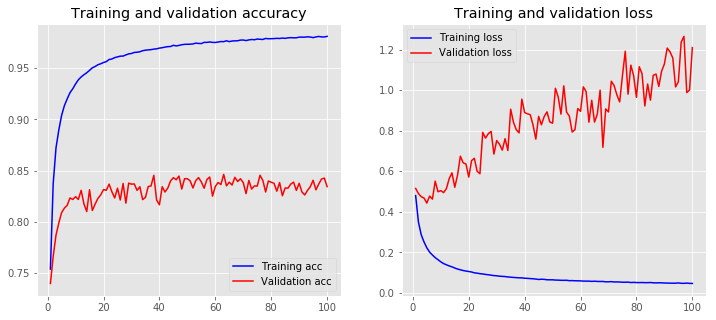

In [18]:
plot_history(history)

### Save model

In [19]:
model.save("model.h5")